<a href="https://colab.research.google.com/github/JorgeSedek/tp3_orga_datos/blob/main/tp3_parte2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
df_train = pd.read_parquet("/content/drive/MyDrive/orgaDatos/TP3 dataset music/train.parquet")

In [ ]:
df_test = pd.read_parquet("/content/drive/MyDrive/orgaDatos/TP3 dataset music/test.parquet")

In [ ]:
df_train.count()

track_name          31383
lyric               31380
genre               31383
language            24021
popularity          31383
artist              31383
a_genres            31383
a_songs             31383
a_popularity        31383
did                  7004
s-label              7004
acousticness        31383
danceability        31383
duration_ms         31383
energy              31383
instrumentalness    31383
key                 31383
liveness            31383
loudness            31383
mode                31383
speechiness         31383
tempo               31383
time_signature      31383
valence             31383
dtype: int64

In [ ]:
def fix_generos(x):
    if x in ["Children’s Music"]:
        return "Children's Music"
    return x
 

df_train.genre = df_train.genre.map(lambda x:fix_generos(x))
df_test.genre = df_test.genre.map(lambda x:fix_generos(x))

In [ ]:
df_train.drop(['track_name','a_genres','did'], axis=1, inplace= True)
df_test.drop(['track_name','a_genres','did'], axis=1, inplace= True)

In [ ]:
df_train['language'].unique()

array(['en', 'es', None, 'it', 'pt', 'fr', 'tl', 'ga', 'ca', 'rw', 'de',
       'is', 'su', 'gl'], dtype=object)

In [ ]:
idioma_mas_popular = df_train['language'].value_counts().reset_index()['index'][0]

In [ ]:
df_train['language'] = df_train['language'].fillna(idioma_mas_popular)
df_test['language'] = df_test['language'].fillna(idioma_mas_popular)

In [ ]:
df_train['language'].unique()

array(['en', 'es', 'it', 'pt', 'fr', 'tl', 'ga', 'ca', 'rw', 'de', 'is',
       'su', 'gl'], dtype=object)

In [ ]:
df_train['s-label'] = df_train['s-label'].fillna(df_train['s-label'].mean())
df_test['s-label'] = df_test['s-label'].fillna(df_test['s-label'].mean())

In [ ]:
df_train.count()

lyric               31380
genre               31383
language            31383
popularity          31383
artist              31383
a_songs             31383
a_popularity        31383
s-label             31383
acousticness        31383
danceability        31383
duration_ms         31383
energy              31383
instrumentalness    31383
key                 31383
liveness            31383
loudness            31383
mode                31383
speechiness         31383
tempo               31383
time_signature      31383
valence             31383
dtype: int64

# Separación de Test y Valid

Para separar el test y valid se utiliza la feature artist:

*   Se mezcla al azar la lista de artistas sin repetir
*   Se toma el 80% de esos artistas
*   se divide el set de entrenamiento:

    1.  las filas que tienen uno de los artistas dentro de la muestra del 80% pasan a ser el nuevo set de entrenamiento.
    2.  el resto pasa a ser el set de validación.




In [ ]:
df_train['artist'].unique()

array(['Beyoncé', 'Bruno Mars', 'Rihanna', ..., 'Christina Milian',
       'Freddie Hubbard', 'Michael Bolton'], dtype=object)

In [ ]:
artistas_shuffled = shuffle(df_train['artist'].unique(), random_state = 8)
artistas_80 = artistas_shuffled[:8*(len(artistas_shuffled)//10)]
len(artistas_80) / len(artistas_shuffled)

0.7985074626865671

In [ ]:
df_train_final = df_train[df_train['artist'].map(lambda x: x in artistas_80)]
df_valid_final = df_train[df_train['artist'].map(lambda x: not (x in artistas_80))]
df_train_final.drop(['artist'], axis=1, inplace= True)
df_valid_final.drop(['artist'], axis=1, inplace= True)
df_test.drop(['artist'], axis=1, inplace= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
y_train = df_train_final.genre
y_test = df_test.genre
x_train = df_train_final.drop("genre", axis = 1)
x_test = df_test.drop("genre", axis = 1)

In [ ]:
y_valid = df_valid_final.genre
x_valid = df_valid_final.drop("genre", axis = 1)

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25242 entries, 0 to 34336
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lyric             25239 non-null  object 
 1   language          25242 non-null  object 
 2   popularity        25242 non-null  int64  
 3   a_songs           25242 non-null  float64
 4   a_popularity      25242 non-null  float64
 5   s-label           25242 non-null  float64
 6   acousticness      25242 non-null  float64
 7   danceability      25242 non-null  float64
 8   duration_ms       25242 non-null  int64  
 9   energy            25242 non-null  float64
 10  instrumentalness  25242 non-null  float64
 11  key               25242 non-null  object 
 12  liveness          25242 non-null  float64
 13  loudness          25242 non-null  float64
 14  mode              25242 non-null  object 
 15  speechiness       25242 non-null  float64
 16  tempo             25242 non-null  float6

# One-hot encoding de features

In [ ]:
def cant_columns_num(x_set):
  cant_columns_num = 0
  for columna in x_set.columns:
    if isinstance(columna, int):
      cant_columns_num += 1
  return cant_columns_num

def renombrar(nombre_feature, x_set):
  for i in range(cant_columns_num(x_set)):
    x_set = x_set.rename(columns = {i: (nombre_feature + str(i))})
  return x_set

In [ ]:
features_ohe = ['language','key','mode','time_signature']

In [ ]:
x_sets = [x_train, x_valid, x_test]

In [ ]:
x_train.columns

Index(['lyric', 'language', 'popularity', 'a_songs', 'a_popularity', 's-label',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [ ]:
for nombre_feature in features_ohe:
  ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
  encoded = ohe.fit_transform(x_train[[nombre_feature]]).todense().astype(int)
  encoded_valid = ohe.transform(x_valid[[nombre_feature]]).todense().astype(int)
  encoded_test = ohe.transform(x_test[[nombre_feature]]).todense().astype(int)

  x_train = x_train.reset_index().drop(['index', nombre_feature],axis=1).join(pd.DataFrame(encoded))
  x_valid = x_valid.reset_index().drop(['index', nombre_feature],axis=1).join(pd.DataFrame(encoded_valid))
  x_test = x_test.reset_index().drop(['index', nombre_feature],axis=1).join(pd.DataFrame(encoded_test))
  
  x_train = renombrar(nombre_feature,x_train)
  x_valid = renombrar(nombre_feature,x_valid)
  x_test = renombrar(nombre_feature,x_test)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [ ]:
x_train.columns

Index(['lyric', 'popularity', 'a_songs', 'a_popularity', 's-label',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'language0', 'language1', 'language2', 'language3',
       'language4', 'language5', 'language6', 'language7', 'language8',
       'language9', 'key0', 'key1', 'key2', 'key3', 'key4', 'key5', 'key6',
       'key7', 'key8', 'key9', 'key10', 'mode0', 'time_signature0',
       'time_signature1', 'time_signature2'],
      dtype='object')

In [ ]:
x_train['lyric'] = x_train['lyric'].map(lambda x: len(str(x)))

In [ ]:
x_valid['lyric'] = x_valid['lyric'].map(lambda x: len(str(x)))

In [ ]:
x_test['lyric'] = x_test['lyric'].map(lambda x: len(str(x)))

In [ ]:
model = LogisticRegression(random_state= 8)
model.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=8)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [ ]:
space = dict()
space['solver'] = ['liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']

In [ ]:
search = RandomizedSearchCV(model, space, n_iter=2, scoring='accuracy', n_jobs= 1, cv=10, random_state= 8, verbose =10)

In [ ]:

result = search.fit(x_train, y_train)

print('Mejor Score: %s' % result.best_score_)
print('Mejor Hiperparametros: %s' % result.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10; 1/2] START penalty=l2, solver=liblinear...............................
[CV 1/10; 1/2] END penalty=l2, solver=liblinear;, score=0.247 total time=   5.2s
[CV 2/10; 1/2] START penalty=l2, solver=liblinear...............................
[CV 2/10; 1/2] END penalty=l2, solver=liblinear;, score=0.223 total time=   5.3s
[CV 3/10; 1/2] START penalty=l2, solver=liblinear...............................
[CV 3/10; 1/2] END penalty=l2, solver=liblinear;, score=0.260 total time=   5.4s
[CV 4/10; 1/2] START penalty=l2, solver=liblinear...............................
[CV 4/10; 1/2] END penalty=l2, solver=liblinear;, score=0.176 total time=  11.3s
[CV 5/10; 1/2] START penalty=l2, solver=liblinear...............................
[CV 5/10; 1/2] END penalty=l2, solver=liblinear;, score=0.208 total time=   7.9s
[CV 6/10; 1/2] START penalty=l2, solver=liblinear...............................
[CV 6/10; 1/2] END penalty=l2, solver=liblinear;

In [ ]:
model2 = LogisticRegression(solver = 'liblinear',penalty = 'l1',random_state= 8)

In [ ]:
model2.fit(x_train, y_train)

LogisticRegression(penalty='l1', random_state=8, solver='liblinear')

In [ ]:
top_k_accuracy_score(y_valid, model2.predict_proba(x_valid), k=2, labels = model.classes_)

0.48314606741573035

el mejor score de validacion obtenido es 0.4831

In [ ]:
top_k_accuracy_score(y_test, model2.predict_proba(x_test), k=2, labels = model.classes_)

0.5050778605280974

el score para test es 0.5051

In [ ]:
prediciones = model2.predict_proba(x_train)

In [ ]:
x_train2 = x_train.copy()

In [ ]:
model.classes_

array(['Alternative', 'Anime', 'Blues', "Children's Music", 'Classical',
       'Comedy', 'Country', 'Dance', 'Electronic', 'Folk', 'Hip-Hop',
       'Indie', 'Jazz', 'Movie', 'Opera', 'Pop', 'R&B', 'Rap', 'Reggae',
       'Reggaeton', 'Rock', 'Ska', 'Soul', 'Soundtrack', 'World'],
      dtype=object)

In [ ]:
i = 0
for genero in model.classes_:
  x_train2[genero] = prediciones[:,i]
  i+= 1

In [ ]:
x_train2

,lyric,popularity,a_songs,a_popularity,s-label,acousticness,danceability,duration_ms,energy,instrumentalness,...,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World
0,1836,79,276.0,205.5,0.490309,0.2720,0.508,261640,0.720,0.000000,...,0.434595,0.043417,0.000910,5.725449e-22,1.916673e-15,0.071086,1.157203e-48,0.050348,3.406027e-16,1.215258e-13
1,1836,80,276.0,205.5,0.490309,0.2720,0.508,261640,0.720,0.000000,...,0.435705,0.042310,0.000947,5.179538e-22,1.773365e-15,0.075531,9.902173e-49,0.048806,3.267850e-16,1.111466e-13
2,1836,80,276.0,205.5,0.490309,0.2720,0.508,261640,0.720,0.000000,...,0.435705,0.042310,0.000947,5.179538e-22,1.773365e-15,0.075531,9.902173e-49,0.048806,3.267850e-16,1.111466e-13
3,1951,71,276.0,205.5,0.490309,0.0296,0.412,319467,0.441,0.072600,...,0.550177,0.046717,0.001547,3.054450e-21,1.690735e-15,0.014394,1.439865e-48,0.032868,1.172714e-15,8.736186e-14
4,1951,71,276.0,205.5,0.490309,0.0296,0.412,319467,0.441,0.072600,...,0.550177,0.046717,0.001547,3.054450e-21,1.690735e-15,0.014394,1.439865e-48,0.032868,1.172714e-15,8.736186e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25237,441,19,89.0,1.0,0.748000,0.6120,0.616,190733,0.822,0.000003,...,0.000231,0.009453,0.000442,3.282160e-02,1.705426e-04,0.005183,2.141461e-01,0.065848,2.922042e-06,1.487514e-01
25238,294,34,89.0,1.0,0.868000,0.8890,0.457,230200,0.369,0.011100,...,0.001226,0.005040,0.000293,4.335740e-03,4.935935e-06,0.023857,3.105210e-03,0.190088,1.463888e-05,1.145463e-01
25239,28,18,89.0,1.0,0.793000,0.7630,0.717,275640,0.566,0.812000,...,0.000026,0.000098,0.000052,2.093339e-03,3.274452e-05,0.002315,4.192842e-04,0.026373,1.047759e-04,6.556798e-02
25240,609,28,89.0,1.0,0.738000,0.8040,0.633,204373,0.553,0.000866,...,0.001360,0.020796,0.000953,1.851534e-02,1.802089e-04,0.009449,1.744272e-02,0.146637,7.996906e-06,8.090704e-02


In [ ]:
x_train2.to_csv('predicciones_parte2.csv', index=False)

In [ ]:
x_train.columns

Index(['lyric', 'popularity', 'a_songs', 'a_popularity', 's-label',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'language0', 'language1', 'language2', 'language3',
       'language4', 'language5', 'language6', 'language7', 'language8',
       'language9', 'key0', 'key1', 'key2', 'key3', 'key4', 'key5', 'key6',
       'key7', 'key8', 'key9', 'key10', 'mode0', 'time_signature0',
       'time_signature1', 'time_signature2'],
      dtype='object')

El dataset de predicciones se compone de los features después de encodear y las predicciones (una columna para cada categoría con su nombre)

In [ ]:
pesos = np.sum(abs(model2.coef_), axis = 0).tolist()
df = pd.DataFrame({'features':x_train.columns,'coef':pesos})
df.sort_values(by=['coef'], ascending=False)

,features,coef
12,speechiness,103.932683
6,danceability,52.108663
17,language2,44.473338
8,energy,42.914858
14,valence,37.330299
5,acousticness,35.737108
9,instrumentalness,32.442332
22,language7,28.288491
16,language1,22.842232
21,language6,16.257604


In [ ]:
features_importantes = df.sort_values(by=['coef'], ascending=False).reset_index().iloc[:10]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

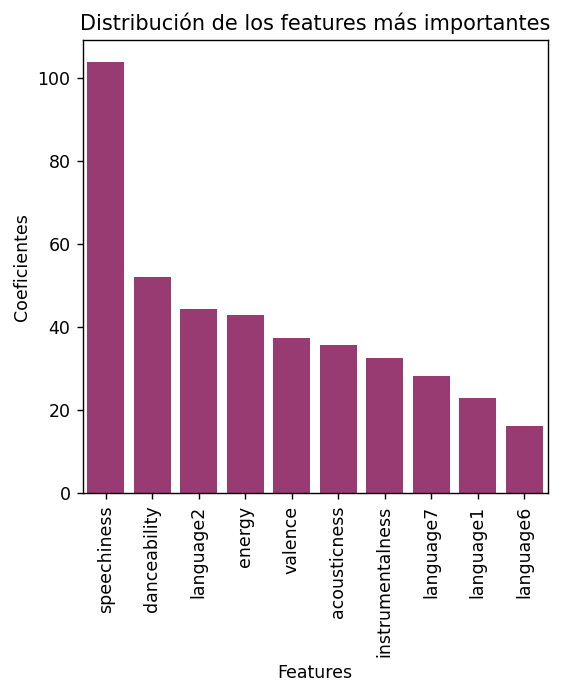

In [ ]:
plt.figure(dpi=125,figsize=(4.8, 4.8))
sns.barplot(data=features_importantes, x="features", y="coef", palette=['#A82C76'])
plt.title("Distribución de los features más importantes")
plt.ylabel('Coeficientes')
plt.xlabel('Features')
plt.xticks(rotation=90)

Los features más importantes son:


*   speechiness
*   daceability
*   language2
*   energy
*   valence
*   acousticness
*   instrumentalness
*   language7
*   language1
*   language6

